In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2025-05-21 06:18:46.172976: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 06:18:46.242654: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 06:18:46.314646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747822726.375491   71837 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747822726.388153   71837 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747822726.444700   71837 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# ================================
# 1. Carregar dados reais e gerados
# ================================
df_all = pd.read_csv("/home/darkcover/Documentos/Gan/Data/df_all.csv")
df_generated = pd.read_csv("/home/darkcover/Documentos/Gan/Data/df_generated.csv")

df_real = df_all[df_all["source"] == "real"].copy()
X_real = df_real.iloc[:, :10].values.astype(np.float32)
y_real = df_real[["X", "Y"]].values.astype(np.float32)

In [3]:
# ================================
# 2. Treinar rede DNN para pseudo-rotulação
#   (2 camadas: 30 e 20 neurônios, 250 epochs, batch_size=100)
# ================================
n_features = X_real.shape[1]
inp = Input(shape=(n_features,))
x = Dense(30, activation='relu')(inp)
x = Dense(20, activation='relu')(x)
out = Dense(2, activation='linear')(x) # Saida linear para as coordernadas X e Y
model_dnn = Model(inputs=inp, outputs=out, name="PseudoLabelModel")

model_dnn.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
X_train, X_val, y_train, y_val = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

model_dnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=250, batch_size=100, verbose=1)
# Salvar o modelo
model_dnn.save("/home/darkcover/Documentos/Gan/Models/pseudo_label_model.keras")


Epoch 1/250


2025-05-21 06:18:52.478399: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 133.8811 - val_loss: 52.1939
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 45.0885 - val_loss: 30.1341
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 29.1097 - val_loss: 25.1584
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24.7247 - val_loss: 21.5194
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 20.3516 - val_loss: 19.4714
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19.9057 - val_loss: 19.5458
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 18.6641 - val_loss: 18.2087
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 17.1468 - val_loss: 16.7954
Epoch 9/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 16.3092 - val_loss: 15.2981
Epoch 10/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 14.1954 - val_loss: 13.5237
Epoch 11/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.5333 - val_loss: 11.4291
Epoch 12/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.3

In [4]:
# ================================
# 3. Predição de pseudo-rotulos nos vetores sinteticos
#    (X, Y) para os dados gerados
# ================================
X_gen = df_generated.iloc[:, :10].values.astype(np.float32)
pseudo = model_dnn.predict(X_gen, verbose=1)
df_generated[['X', 'Y']] = pseudo

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [5]:
# ================================
# 4. Avaliar realismo via Discriminador (critério 2)
#   (Modelo DNN com 2 camadas: 30 e 20 neurônios, 250 epochs, batch_size=100)
# ================================
# Carregar o modelo do discriminador
discriminator = load_model("/home/darkcover/Documentos/Gan/Models/Modelsdiscriminator.keras")
d_score = discriminator.predict(X_gen, verbose=1)
df_generated['D_score'] = d_score.flatten()

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [6]:
# ================================
# 5. Dividir ambiente em zonas de 4m^2 (2x2m) e selecionar 1000 amostras
#    (X, Y) para cada zona
# ================================
L, W = 20, 20
zone_size = 2
nx, ny = int(L / zone_size), int(W / zone_size)
num_zones = nx * ny
ms = 1000
nj = ms // num_zones

# Calcular rotulos de zona
df_generated['zone_x'] = np.minimum((df_generated['X'] // zone_size).astype(int), nx - 1)
df_generated['zone_y'] = np.minimum((df_generated['Y'] // zone_size).astype(int), ny - 1)
df_generated['zone_id'] = df_generated['zone_x'] + nx * df_generated['zone_y']

# Selecionar top-nj por zona segundo D_score
selected_blocks, zone_logs = [], []
for zone, group in df_generated.groupby('zone_id'):
    topk = group.nlargest(nj, 'D_score')
    selected_blocks.append(topk)
    zone_logs.append((zone, len(group), topk['D_score'].mean()))

df_selected = pd.concat(selected_blocks, ignore_index=True)
df_selected.to_csv("/home/darkcover/Documentos/Gan/Data/df_selected_synthetic.csv", index=False)


Total sintéticas selecionadas: 221
Zona 053: 4 geradas, D_score médio selecionadas 1.000
Zona 059: 1 geradas, D_score médio selecionadas 1.000
Zona 060: 192 geradas, D_score médio selecionadas 1.000
Zona 061: 364 geradas, D_score médio selecionadas 1.000
Zona 062: 609 geradas, D_score médio selecionadas 1.000
Zona 063: 443 geradas, D_score médio selecionadas 1.000
Zona 064: 107 geradas, D_score médio selecionadas 1.000
Zona 065: 8 geradas, D_score médio selecionadas 1.000
Zona 069: 17 geradas, D_score médio selecionadas 1.000
Zona 070: 3106 geradas, D_score médio selecionadas 1.000
Zona 071: 8942 geradas, D_score médio selecionadas 1.000
Zona 072: 4592 geradas, D_score médio selecionadas 1.000
Zona 073: 1692 geradas, D_score médio selecionadas 1.000
Zona 074: 246 geradas, D_score médio selecionadas 1.000
Zona 075: 24 geradas, D_score médio selecionadas 1.000
Zona 080: 2932 geradas, D_score médio selecionadas 1.000
Zona 081: 13035 geradas, D_score médio selecionadas 1.000
Zona 082: 2819

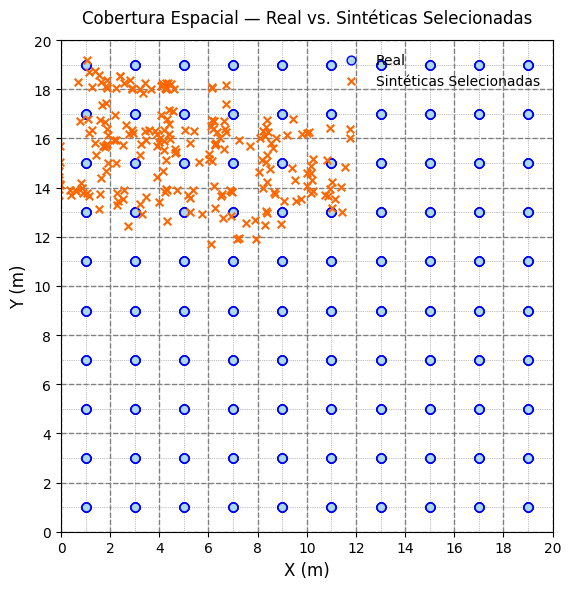

In [7]:
# ================================
# 6. Logs e Visualizações
# ================================
print("Total sintéticas selecionadas:", len(df_selected))
for zid, total, avg in zone_logs:
    print(f"Zona {zid:03d}: {total} geradas, D_score médio selecionadas {avg:.3f}")

L, W        = 20, 20
zone_size   = 2.0

fig, ax = plt.subplots(figsize=(6,6))
# Pontos reais: círculos vazados
ax.scatter(df_real['X'], df_real['Y'],
           facecolors='lightblue', edgecolors='blue',
           s=40, label='Real')

# Pontos sintéticos: xis laranja
ax.scatter(df_selected['X'], df_selected['Y'],
           marker='x', c='#FF6600',
           s=30, label='Sintéticas Selecionadas')

# Desenha grid fino tracejado a cada 1 m
for coord in np.arange(0, L+1, 1):
    ax.axvline(coord, linestyle=':', linewidth=0.5, color='gray', zorder=0)
    ax.axhline(coord, linestyle=':', linewidth=0.5, color='gray', zorder=0)

# Delimitações das zonas (a cada 2 m)
for coord in np.arange(0, L+zone_size, zone_size):
    ax.axvline(coord, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axhline(coord, linestyle='--', linewidth=1, color='gray', zorder=0)

ax.set_xlim(0, L)
ax.set_ylim(0, W)
ax.set_aspect('equal', 'box')
ax.set_xticks(np.arange(0, L+1, 2))
ax.set_yticks(np.arange(0, W+1, 2))
ax.set_xlabel("X (m)", fontsize=12)
ax.set_ylabel("Y (m)", fontsize=12)
ax.legend(frameon=False, loc='upper right', fontsize=10)
ax.set_title("Cobertura Espacial — Real vs. Sintéticas Selecionadas", pad=12)

plt.tight_layout()
plt.show()


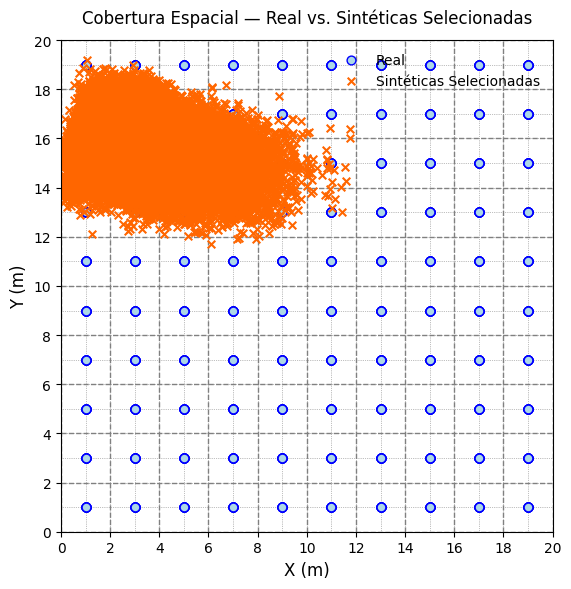

In [9]:
L, W        = 20, 20
zone_size   = 2.0

fig, ax = plt.subplots(figsize=(6,6))
# Pontos reais: círculos vazados
ax.scatter(df_real['X'], df_real['Y'],
           facecolors='lightblue', edgecolors='blue',
           s=40, label='Real')

# Pontos sintéticos: xis laranja
ax.scatter(df_generated['X'], df_generated['Y'],
           marker='x', c='#FF6600',
           s=30, label='Sintéticas Selecionadas')

# Desenha grid fino tracejado a cada 1 m
for coord in np.arange(0, L+1, 1):
    ax.axvline(coord, linestyle=':', linewidth=0.5, color='gray', zorder=0)
    ax.axhline(coord, linestyle=':', linewidth=0.5, color='gray', zorder=0)

# Delimitações das zonas (a cada 2 m)
for coord in np.arange(0, L+zone_size, zone_size):
    ax.axvline(coord, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axhline(coord, linestyle='--', linewidth=1, color='gray', zorder=0)

ax.set_xlim(0, L)
ax.set_ylim(0, W)
ax.set_aspect('equal', 'box')
ax.set_xticks(np.arange(0, L+1, 2))
ax.set_yticks(np.arange(0, W+1, 2))
ax.set_xlabel("X (m)", fontsize=12)
ax.set_ylabel("Y (m)", fontsize=12)
ax.legend(frameon=False, loc='upper right', fontsize=10)
ax.set_title("Cobertura Espacial — Real vs. Sintéticas Selecionadas", pad=12)

plt.tight_layout()
plt.show()
